In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!python --version

Python 3.7.12



--- RandomForestClassifier Feature Importance ---
     Feature  Importance
4  feature_4    0.206109
9  feature_9    0.167711
0  feature_0    0.159516
5  feature_5    0.143680
3  feature_3    0.120340
6  feature_6    0.069936
1  feature_1    0.065147
8  feature_8    0.025048
2  feature_2    0.021608
7  feature_7    0.020905

--- XGBClassifier Feature Importance ---
     Feature  Importance
9  feature_9    0.246176
4  feature_4    0.179213
5  feature_5    0.166644
3  feature_3    0.139662
0  feature_0    0.121020
1  feature_1    0.054325
6  feature_6    0.047176
8  feature_8    0.024042
7  feature_7    0.013442
2  feature_2    0.008300


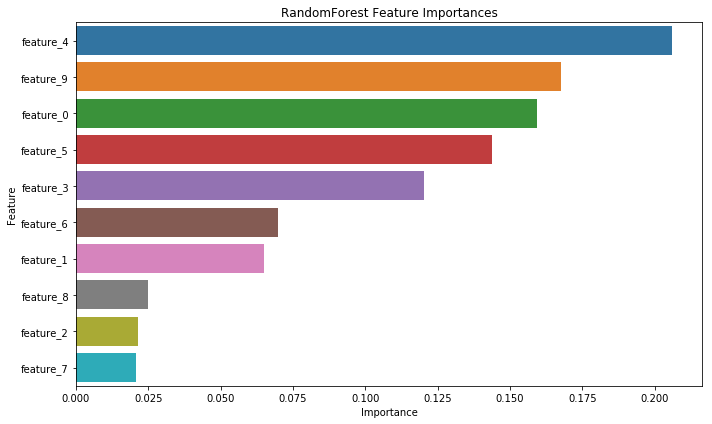

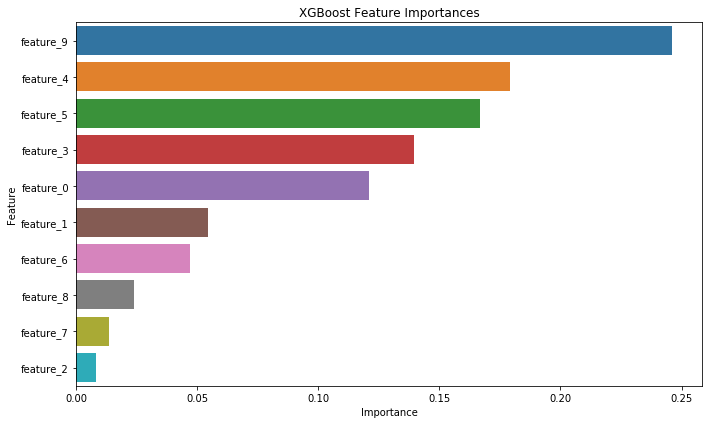

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.datasets import make_classification

# 1. 데이터 준비
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=2, random_state=42)
feature_names = [f'feature_{i}' for i in range(X.shape[1])]
X_df = pd.DataFrame(X, columns=feature_names)

X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.2, random_state=42)

# 2. RandomForestClassifier를 이용한 변수 중요도 확인
print("\n--- RandomForestClassifier Feature Importance ---")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

rf_importances = rf_model.feature_importances_
rf_feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': rf_importances})
rf_feature_importance_df = rf_feature_importance_df.sort_values(by='Importance', ascending=False)
print(rf_feature_importance_df)
'''
     Feature  Importance
4  feature_4    0.206109
9  feature_9    0.167711
0  feature_0    0.159516
5  feature_5    0.143680
3  feature_3    0.120340
6  feature_6    0.069936
1  feature_1    0.065147
8  feature_8    0.025048
2  feature_2    0.021608
7  feature_7    0.020905
'''

# 3. XGBClassifier를 이용한 변수 중요도 확인
print("\n--- XGBClassifier Feature Importance ---")
xgb_model = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

xgb_importances = xgb_model.feature_importances_
xgb_feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': xgb_importances})
xgb_feature_importance_df = xgb_feature_importance_df.sort_values(by='Importance', ascending=False)
print(xgb_feature_importance_df)
'''
     Feature  Importance
9  feature_9    0.246176
4  feature_4    0.179213
5  feature_5    0.166644
3  feature_3    0.139662
0  feature_0    0.121020
1  feature_1    0.054325
6  feature_6    0.047176
8  feature_8    0.024042
7  feature_7    0.013442
2  feature_2    0.008300
'''

# 4. 변수 중요도 시각화 (RandomForest)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=rf_feature_importance_df)
plt.title('RandomForest Feature Importances')
plt.tight_layout()
plt.show()

# 5. 변수 중요도 시각화 (XGBoost)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=xgb_feature_importance_df)
plt.title('XGBoost Feature Importances')
plt.tight_layout()
plt.show()

In [14]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 1. 데이터 준비
X, y = make_regression(n_samples=100, n_features=10, n_informative=5, random_state=42)
feature_names = [f'X{i}' for i in range(X.shape[1])]
X_df = pd.DataFrame(X, columns=feature_names)
X_df = sm.add_constant(X_df) # 상수항 추가

X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.2, random_state=42)

def backward_elimination(X_data, y_data, significance_level=0.05):
    features = list(X_data.columns)
    while len(features) > 1: # 상수항(const)은 남겨둠
        model = sm.OLS(y_data, X_data[features]).fit()
        p_values = model.pvalues
        max_p_value = p_values.drop('const', errors='ignore').max() # 상수항 제외
        
        if max_p_value > significance_level:
            redundant_feature = p_values.drop('const', errors='ignore').idxmax()
            features.remove(redundant_feature)
            print(f"제거된 피처: {redundant_feature}, p-value: {max_p_value:.4f}")
        else:
            break
    return features

# 2. 후진 제거법 적용
print("--- 후진 제거법 시작 ---")
selected_features_be = backward_elimination(X_train, y_train)
print(f"최종 선택된 피처: {selected_features_be}")
'''
제거된 피처: X5, p-value: 0.1832
제거된 피처: X6, p-value: 0.7410
제거된 피처: X7, p-value: 0.2208
최종 선택된 피처: ['const', 'X0', 'X1', 'X2', 'X3', 'X4', 'X8', 'X9']
'''

# 3. 최종 모델 학습 및 평가
final_model_be = sm.OLS(y_train, X_train[selected_features_be]).fit()
print("\n--- 후진 제거법 최종 모델 요약 ---")
print(final_model_be.summary())
'''
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.011e+31
Date:                Mon, 13 Oct 2025   Prob (F-statistic):               0.00
Time:                        23:07:59   Log-Likelihood:                 2283.6
No. Observations:                  80   AIC:                            -4551.
Df Residuals:                      72   BIC:                            -4532.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -8.882e-15   1.16e-14     -0.767      0.446    -3.2e-14    1.42e-14
X0          7.194e-14   1.14e-14      6.317      0.000    4.92e-14    9.46e-14
X1            63.6430   1.23e-14   5.18e+15      0.000      63.643      63.643
X2            70.6476   1.21e-14   5.83e+15      0.000      70.648      70.648
X3            10.4568   1.12e-14   9.36e+14      0.000      10.457      10.457
X4            16.7483   1.25e-14   1.34e+15      0.000      16.748      16.748
X8             3.1586   1.16e-14   2.71e+14      0.000       3.159       3.159
X9          3.997e-14   1.29e-14      3.106      0.003    1.43e-14    6.56e-14
==============================================================================
Omnibus:                        1.007   Durbin-Watson:                   1.736
Prob(Omnibus):                  0.604   Jarque-Bera (JB):                1.051
Skew:                          -0.254   Prob(JB):                        0.591
Kurtosis:                       2.759   Cond. No.                         1.65
==============================================================================
'''

y_pred_be = final_model_be.predict(X_test[selected_features_be])
mse_be = mean_squared_error(y_test, y_pred_be)
print(f"테스트 세트 MSE (후진 제거법): {mse_be:.4f}") # 0.0000

--- 후진 제거법 시작 ---
제거된 피처: X7, p-value: 0.6061
제거된 피처: X9, p-value: 0.3776
제거된 피처: X5, p-value: 0.3920
제거된 피처: X6, p-value: 0.0913
최종 선택된 피처: ['const', 'X0', 'X1', 'X2', 'X3', 'X4', 'X8']

--- 후진 제거법 최종 모델 요약 ---
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.397e+31
Date:                Sat, 14 Feb 2026   Prob (F-statistic):               0.00
Time:                        22:44:31   Log-Likelihood:                 2311.4
No. Observations:                  80   AIC:                            -4609.
Df Residuals:                      73   BIC:                            -4592.
Df Model:                           6                                         
Covariance Type:            nonrobust                                        

In [15]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 1. 데이터 준비 (후진 제거법 예시와 동일)
X, y = make_regression(n_samples=100, n_features=10, n_informative=5, random_state=42)
feature_names = [f'X{i}' for i in range(X.shape[1])]
X_df = pd.DataFrame(X, columns=feature_names)
X_df = sm.add_constant(X_df) # 상수항 추가

X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.2, random_state=42)

def forward_selection(X_data, y_data, significance_level=0.05):
    initial_features = ['const'] # 상수항부터 시작
    remaining_features = list(set(X_data.columns) - set(initial_features))
    selected_features = list(initial_features)

    while remaining_features:
        best_p_value = 1.0
        best_feature = None
        
        for feature in remaining_features:
            model = sm.OLS(y_data, X_data[selected_features + [feature]]).fit()
            p_value = model.pvalues[feature]
            
            if p_value < best_p_value:
                best_p_value = p_value
                best_feature = feature
        
        if best_feature and best_p_value < significance_level:
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
            print(f"추가된 피처: {best_feature}, p-value: {best_p_value:.4f}")
        else:
            break
    return selected_features

# 2. 전진 선택법 적용
print("--- 전진 선택법 시작 ---")
selected_features_fs = forward_selection(X_train, y_train)
print(f"최종 선택된 피처: {selected_features_fs}")
'''
추가된 피처: X2, p-value: 0.0000
추가된 피처: X1, p-value: 0.0000
추가된 피처: X4, p-value: 0.0000
추가된 피처: X3, p-value: 0.0000
추가된 피처: X8, p-value: 0.0000
추가된 피처: X0, p-value: 0.0000
추가된 피처: X9, p-value: 0.0000
추가된 피처: X6, p-value: 0.0001
추가된 피처: X5, p-value: 0.0001
추가된 피처: X7, p-value: 0.0083
최종 선택된 피처: ['const', 'X2', 'X1', 'X4', 'X3', 'X8', 'X0', 'X9', 'X6', 'X5', 'X7']
'''

# 3. 최종 모델 학습 및 평가
final_model_fs = sm.OLS(y_train, X_train[selected_features_fs]).fit()
print("\n--- 전진 선택법 최종 모델 요약 ---")
print(final_model_fs.summary())
'''
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.014e+31
Date:                Mon, 13 Oct 2025   Prob (F-statistic):               0.00
Time:                        23:10:48   Log-Likelihood:                 2299.7
No. Observations:                  80   AIC:                            -4577.
Df Residuals:                      69   BIC:                            -4551.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.043e-14   9.69e-15      2.107      0.039    1.09e-15    3.98e-14
X2            70.6476   1.04e-14   6.82e+15      0.000      70.648      70.648
X1            63.6430   1.04e-14   6.09e+15      0.000      63.643      63.643
X4            16.7483   1.06e-14   1.58e+15      0.000      16.748      16.748
X3            10.4568   9.61e-15   1.09e+15      0.000      10.457      10.457
X8             3.1586   9.86e-15    3.2e+14      0.000       3.159       3.159
X0         -5.151e-14   9.85e-15     -5.230      0.000   -7.12e-14   -3.19e-14
X9         -1.776e-14   1.08e-14     -1.641      0.105   -3.94e-14    3.83e-15
X6         -2.665e-14   9.93e-15     -2.682      0.009   -4.65e-14   -6.83e-15
X5         -6.217e-15   1.13e-14     -0.549      0.585   -2.88e-14    1.64e-14
X7          -3.02e-14   1.11e-14     -2.717      0.008   -5.24e-14   -8.03e-15
==============================================================================
Omnibus:                        2.323   Durbin-Watson:                   1.794
Prob(Omnibus):                  0.313   Jarque-Bera (JB):                1.706
Skew:                           0.178   Prob(JB):                        0.426
Kurtosis:                       3.620   Cond. No.                         1.87
==============================================================================
'''

y_pred_fs = final_model_fs.predict(X_test[selected_features_fs])
mse_fs = mean_squared_error(y_test, y_pred_fs)
print(f"테스트 세트 MSE (전진 선택법): {mse_fs:.4f}") # 0.0000

--- 전진 선택법 시작 ---
추가된 피처: X2, p-value: 0.0000
추가된 피처: X1, p-value: 0.0000
추가된 피처: X4, p-value: 0.0000
추가된 피처: X3, p-value: 0.0000
추가된 피처: X8, p-value: 0.0000
추가된 피처: X0, p-value: 0.0000
추가된 피처: X7, p-value: 0.0221
추가된 피처: X6, p-value: 0.0000
추가된 피처: X9, p-value: 0.0006
최종 선택된 피처: ['const', 'X2', 'X1', 'X4', 'X3', 'X8', 'X0', 'X7', 'X6', 'X9']

--- 전진 선택법 최종 모델 요약 ---
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 8.370e+30
Date:                Sat, 14 Feb 2026   Prob (F-statistic):               0.00
Time:                        22:44:59   Log-Likelihood:                 2287.3
No. Observations:                  80   AIC:                            -4555.
Df Residuals:                      70   BIC:                            -4531